# Burnman Tutorial
By: Neala Creasy

Sources: Burnman examples (https://burnman.org/)

Here is a tutorial that combines many aspects of Burnman into one tutorial. 
I have combined small segments from many examples to give a comprehesive overview of the most important aspects of Burnman. 

The first things to do is load modules, like numpy and matlplotlib

In [1]:
import os, sys, numpy as np, matplotlib.pyplot as plt
sys.path.insert(1,os.path.abspath('../..'))

Then need to import burnman

In [2]:
import burnman
from burnman import minerals

This uploads the PREM seismic model. Other models can be uploaded, but you need to be award of what is included in this files. PREM is the easiest to work with in Burnman. You can also upload your own. Go to burnman/data/input_seismic to see all options. 

In [3]:
seismic_model = burnman.seismic.PREM()

Below creates a plot of PREM. We create an array of 20 depths at which we want to evaluate PREM, and then query the seismic model for the pressure, density, P wave speed, S wave
speed, and bulk sound velocity at those depths.

Take note of new commands: plt.xlabel, plt.xlim, plt.legend.

Try exploring plt.ylim

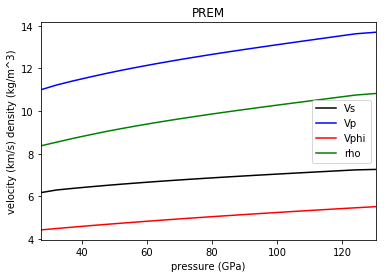

In [11]:
depths = np.linspace(750e3, 2800e3, 20)
pressure, seis_rho, seis_vp, seis_vs, seis_vphi = \
                        seismic_model.evaluate(['pressure','density','v_p','v_s','v_phi'],depths)

plt.plot(pressure/1.e9,seis_vs/1.e3,'k',label='Vs')
plt.plot(pressure/1.e9,seis_vp/1.e3,'b',label='Vp')
plt.plot(pressure/1.e9,seis_rho/1.e3,'r',label='Vphi')
plt.plot(pressure/1.e9,seis_vphi/1.e3,'g',label='rho')
plt.xlabel('pressure (GPa)')
plt.ylabel('velocity (km/s) density (kg/m^3)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.title('PREM')
plt.legend();
#plt.ylim()
plt.show()

In [7]:
help(seismic_model.evaluate)

Help on method evaluate in module burnman.seismic:

evaluate(vars_list, depth_list) method of burnman.seismic.PREM instance
    Returns the lists of data for a Seismic1DModel for the depths provided
    
    Parameters
    ----------
    vars_list : array of str
        Available variables depend on the seismic model, and can be chosen from 'pressure','density','gravity','v_s','v_p','v_phi','G','K','QG','QK'
    depth_list : array of floats
        Array of depths [m] to evaluate seismic model at.
    
    Returns
    -------
    Array of values shapes as (len(vars_list),len(depth_list)).



## Section 1: Making a rock

A mixture of MgSiO3 and MgO. burnman.composite creates mixtures of whatever minerals you want to calculate. 


Challenge 1: Make a new mineral with made up values or a mineral that you study and calculate the seismic velocities!


In [22]:
rock = burnman.Composite([minerals.SLB_2011.mg_perovskite(), minerals.SLB_2011.periclase()], \
                         [0.8, 0.2])

In [24]:
help(burnman.Composite)
# you can use the help command here to see what commands you can use with rock. For example,
# rock.set_method
# rock.set_fractions, etc.


Help on class Composite in module burnman.composite:

class Composite(burnman.material.Material)
 |  Base class for a composite material.
 |  The static phases can be minerals or materials,
 |  meaning composite can be nested arbitrarily.
 |  
 |  The fractions of the phases can be input
 |  as either 'molar' or 'mass' during instantiation,
 |  and modified (or initialised) after this point by
 |  using set_fractions.
 |  
 |  This class is available as ``burnman.Composite``.
 |  
 |  Method resolution order:
 |      Composite
 |      burnman.material.Material
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, phases, fractions=None, fraction_type='molar')
 |      Create a composite using a list of phases and their fractions (adding to 1.0).
 |      
 |      Parameters
 |      ----------
 |      phases: list of :class:`burnman.Material`
 |          list of phases.
 |      fractions: list of floats
 |          molar or mass fraction for each phase.
 |      fr

TypeError: '>=' not supported between instances of 'float' and 'NoneType'

### Temperature Profiles

The next step is pick a temperature profile so that your equation of state calculates vp and vs for particular temperatures. 

Below, I am using Brown and Shankland (1981), but Burnman has many profiles you can pick from (burnman/data/input_geotherm). 

The command burnman.geotherm takes the pressures previoulsy outlined and interpolates temperature for those pressures. 

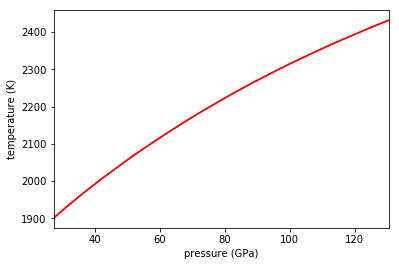

In [17]:
temperature = burnman.geotherm.brown_shankland(pressure)
plt.plot(pressure/1.e9,temperature,'r')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel('pressure (GPa)')
plt.ylabel('temperature (K)');
plt.show()

In [18]:
#here are the temperatures
print(temperature)

[ 1900.72277228  1936.67526316  1971.33263158  2004.80526316  2037.17368421
  2069.17263158  2099.38315789  2129.25105263  2158.38263158  2186.51315789
  2214.06631579  2240.80210526  2266.69684211  2291.77526316  2316.59105263
  2340.43263158  2364.11631579  2386.77421053  2409.43210526  2431.8       ]


In [19]:
help(burnman.geotherm)

Help on module burnman.geotherm in burnman:

NAME
    burnman.geotherm

DESCRIPTION
    # This file is part of BurnMan - a thermoelastic and thermodynamic toolkit for the Earth and Planetary Sciences
    # Copyright (C) 2012 - 2015 by the BurnMan team, released under the GNU
    # GPL v2 or later.

FUNCTIONS
    adiabatic(pressures, T0, rock)
        This calculates a geotherm based on an anchor temperature and a rock,
        assuming that the rock's temperature follows an adiabatic gradient with
        pressure. This amounts to integrating:
        
        .. math::
            \frac{\partial T}{\partial P} = \frac{ \gamma  T}{ K_s }
        
        where :math:`\gamma` is the Grueneisen parameter and :math:`K_s` is
        the adiabatic bulk modulus.
        
        Parameters
        ----------
        
        pressures : list of floats
            The list of pressures in :math:`[Pa]` at which to evaluate the geotherm.
        
        T0 : float
            An anchor tempera

Now, time to calculate seismic velocities!


In [25]:
density, vp, vs, vphi, K, G = rock.evaluate(['density','v_p','v_s','v_phi','K_S','G'], pressure, temperature)

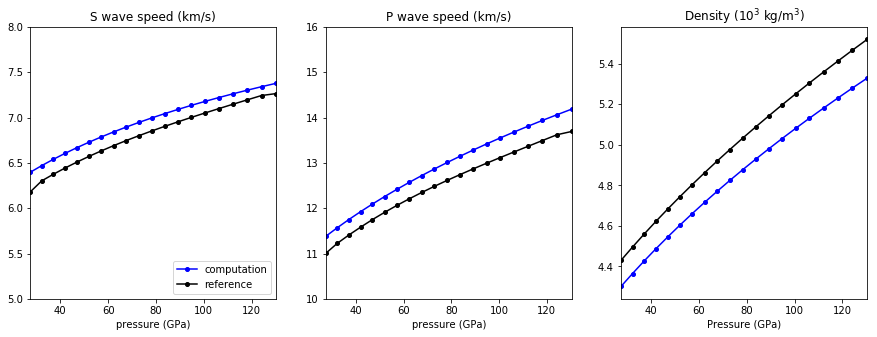

In [32]:
# First, we plot the s-wave speed verses the PREM s-wave speed
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pressure/1.e9,vs/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4,label='computation')
plt.plot(pressure/1.e9,seis_vs/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4,label='reference')
plt.title("S wave speed (km/s)")
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel('pressure (GPa)')
plt.legend(loc='lower right')
plt.ylim(5,8.0)
  

# Next, we plot the p-wave speed verses the PREM p-wave speed
plt.subplot(1,3,2)
plt.plot(pressure/1.e9,vp/1.e3,color='b',linestyle='-',marker='o',markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_vp/1.e3,color='k',linestyle='-',marker='o',markerfacecolor='k',markersize=4)
plt.title("P wave speed (km/s)")
plt.xlabel('pressure (GPa)')
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.ylim(10,16)
    
# Next, we plot the density verses the PREM density
plt.subplot(1,3,3)
plt.plot(pressure/1.e9,density/1.e3,color='b',linestyle='-',marker='o', markerfacecolor='b',markersize=4)
plt.plot(pressure/1.e9,seis_rho/1.e3,color='k',linestyle='-',marker='o', markerfacecolor='k',markersize=4)
plt.xlim(min(pressure)/1.e9,max(pressure)/1.e9)
plt.xlabel("Pressure (GPa)")

plt.title("Density ($10^3$ kg/m$^3$)");

#to save a figure. This command must be before plt.show() and after all of your 
#plotting commands
plt.savefig('burnman_example.eps', format='eps', dpi=2000)


plt.show()




Here is how to save your calculations and/or figures

In [30]:
#to save a figure (see above):
plt.savefig('burnman_blank.eps', format='eps', dpi=2000)

#this command will just save a blank figure. This command is very important in its placement

In [43]:
#now to save your calculations in a text file:
output_filename = "Burnman_example.txt"
f = open(output_filename, 'wb')
header = "#Pressure\tTemperature\tdensity\tvp\tvp\tvs\tvphi\tK\tG\n"
f.write(header.encode('utf-8'))

data = list(
    zip(pressure, temperature, density, vp, vs, vphi, K, G))
np.savetxt(f, data, fmt='%.10e', delimiter='\t')

#sometimes I have to run this a couple of times for the data to save (not sure why)
#someone better at python might know why...

To make a new mineral in the mineral database: 
Copy and paste another mineral and individually change the important values. 

## Section 2: Solid Solution

Make a rock with a solid solution between mg-, fe-, and al-perovskites.

If you look at file SLB_2011.py, it will tell you what is needed for the solid solution:

class mg_fe_perovskite(SolidSolution):

    def __init__(self, molar_fractions=None):
        self.name = 'magnesium silicate perovskite/bridgmanite'
        self.type = 'symmetric'
        self.endmembers = [[mg_perovskite(), '[Mg][Si]O3'], [
                           fe_perovskite(), '[Fe][Si]O3'], [al_perovskite(), '[Al][Al]O3']]
        self.energy_interaction = [[0.0, 116.0e3], [0.0]]

        SolidSolution.__init__(self, molar_fractions)
        
        
Challenge 2: Compare different solid solutions (either different combinations of perovskite or some other solid solution)

Challenge 3: Try different mixing methods. 

In [45]:
# choose the solid solution
preset_solidsolution = minerals.SLB_2011.mg_fe_perovskite()

# Set molar_fraction of mg_perovskite, fe_perovskite, and al-perovskite
preset_solidsolution.set_composition([0.9, 0.1, 0.])  

# Now put solid solution into a rock with periclase
rock = burnman.Composite([preset_solidsolution, minerals.SLB_2011.periclase()], [0.8, 0.2])

Calculations are done for:
Composite:
  0.8 of
    'burnman.minerals.SLB_2011.mg_fe_perovskite'
  0.2 of
    'burnman.minerals.SLB_2011.periclase'


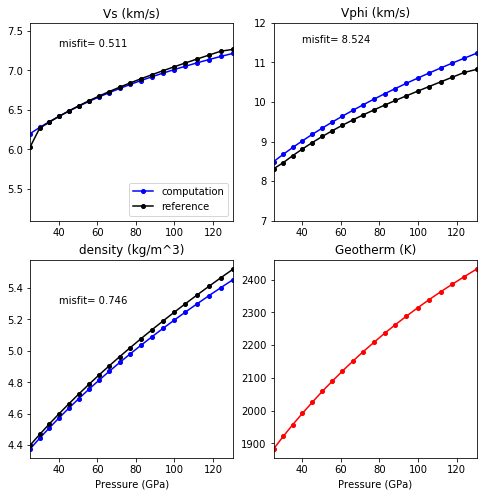

In [51]:
# now run all of the burnman calculations:
seismic_model = burnman.seismic.PREM()
number_of_points = 20  
depths = np.linspace(700e3, 2800e3, number_of_points)

seis_p, seis_rho, seis_vp, seis_vs, seis_vphi = seismic_model.evaluate(
    ['pressure', 'density', 'v_p', 'v_s', 'v_phi'], depths)

temperature = burnman.geotherm.brown_shankland(seis_p)

print("Calculations are done for:")
rock.debug_print()

mat_rho, mat_vp, mat_vphi, mat_vs, mat_K, mat_G = rock.evaluate(
    ['density', 'v_p', 'v_phi', 'v_s', 'K_S', 'G'], seis_p, temperature)

#calculates an difference between PREM and rock calculated here
[vs_err, vphi_err, rho_err] = burnman.compare_chifactor(
    [mat_vs, mat_vphi, mat_rho], [seis_vs, seis_vphi, seis_rho])

    # PLOTTING
# plot vs
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(
    seis_p / 1.e9, mat_vs / 1.e3, color='b', linestyle='-', marker='o',
    markerfacecolor='b', markersize=4, label='computation')
plt.plot(
    seis_p / 1.e9, seis_vs / 1.e3, color='k', linestyle='-', marker='o',
    markerfacecolor='k', markersize=4, label='reference')
plt.title("Vs (km/s)")
plt.xlim(min(seis_p) / 1.e9, max(seis_p) / 1.e9)
plt.ylim(5.1, 7.6)
plt.legend(loc='lower right')
plt.text(40, 7.3, "misfit= %3.3f" % vs_err)

# plot Vphi
plt.subplot(2, 2, 2)
plt.plot(
    seis_p / 1.e9, mat_vphi / 1.e3, color='b', linestyle='-', marker='o',
    markerfacecolor='b', markersize=4)
plt.plot(
    seis_p / 1.e9, seis_vphi / 1.e3, color='k', linestyle='-', marker='o',
    markerfacecolor='k', markersize=4)
plt.title("Vphi (km/s)")
plt.xlim(min(seis_p) / 1.e9, max(seis_p) / 1.e9)
plt.ylim(7, 12)
plt.text(40, 11.5, "misfit= %3.3f" % vphi_err)

# plot density
plt.subplot(2, 2, 3)
plt.plot(
    seis_p / 1.e9, mat_rho / 1.e3, color='b', linestyle='-', marker='o',
    markerfacecolor='b', markersize=4)
plt.plot(
    seis_p / 1.e9, seis_rho / 1.e3, color='k', linestyle='-', marker='o',
    markerfacecolor='k', markersize=4)
plt.title("density (kg/m^3)")
plt.xlim(min(seis_p) / 1.e9, max(seis_p) / 1.e9)
plt.text(40, 5.3, "misfit= %3.3f" % rho_err)
plt.xlabel("Pressure (GPa)")

# plot geotherm
plt.subplot(2, 2, 4)
plt.plot(seis_p / 1e9, temperature, color='r', linestyle='-', marker='o',
    markerfacecolor='r', markersize=4)
plt.title("Geotherm (K)")
plt.xlim(min(seis_p) / 1.e9, max(seis_p) / 1.e9)
plt.xlabel("Pressure (GPa)")
plt.show()